In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np

### Load data

In [2]:
file_name = "DEBRV_DEHAM_historical_routes.csv"

In [3]:
raw_data = pd.read_csv(file_name)
raw_data.head()

,id,from_seq,to_seq,from_port,to_port,leg_duration,count,points
0,imo_9462794,127,128,DEBRV,DEHAM,36406308,135,"[[8.489074, 53.615707, 1509423228430, 14.0], [..."
1,imo_9454230,196,197,DEBRV,DEHAM,37389167,155,"[[8.48967, 53.614338, 1507290057531, 12.5], [8..."
2,imo_9454230,241,242,DEBRV,DEHAM,35623991,196,"[[8.499015, 53.60522, 1509682757817, 15.9], [8..."
3,imo_9372200,150,151,DEBRV,DEHAM,34345681,156,"[[8.495334, 53.609833, 1511932247447, 11.2], [..."
4,imo_9376048,116,117,DEHAM,DEBRV,32515761,189,"[[9.915167, 53.542168, 1508734759773, 7.6], [9..."


In [4]:
raw_data['id'] = raw_data['id'].astype(str)
raw_data['from_port'] = raw_data['from_port'].astype(str)
raw_data['to_port'] = raw_data['to_port'].astype(str)

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            728 non-null    object
 1   from_seq      728 non-null    int64 
 2   to_seq        728 non-null    int64 
 3   from_port     728 non-null    object
 4   to_port       728 non-null    object
 5   leg_duration  728 non-null    int64 
 6   count         728 non-null    int64 
 7   points        728 non-null    object
dtypes: int64(4), object(4)
memory usage: 45.6+ KB


#### Create a new frame from flatten points list

In [6]:
debrv_deham = raw_data[raw_data.from_port.str.contains("DEBRV")]

data_list = list()
for row in debrv_deham.itertuples(index=False):
    parsed_list = json.loads(row.points)
    for item in parsed_list:
        item.append(row.id)
    data_list += parsed_list
    
    df = pd.DataFrame(data_list, columns=['longitude', 'latitude', 'timestamp', 'speed', 'vessel_id'])
    df.head()

### Find average coordinates of start point

In [9]:
first_timestamp_idx = df.groupby('vessel_id')['timestamp'].idxmin()
df_1st = df.loc[first_timestamp_idx]
df_1st.head()

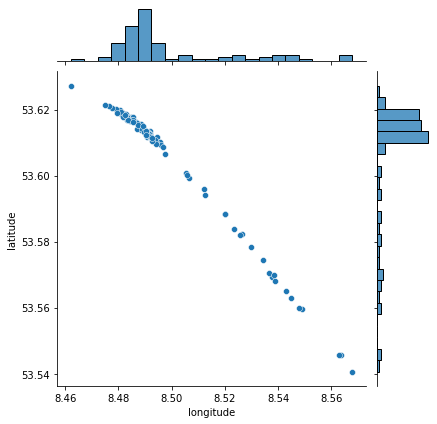

In [12]:
sns.jointplot(data=df_1st, y="latitude", x="longitude")

In [13]:
median_value = df_1st.median()
print(median_value)

longitude    8.490376e+00
latitude     5.361317e+01
timestamp    1.501168e+12
speed        1.240000e+01
dtype: float64


In [14]:
median_longitude = median_value.longitude
median_latitude = median_value.latitude